In [2]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Convolution1D, MaxPooling1D, Flatten,  Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

np.random.seed(7)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore") 



In [4]:
df = pd.read_hdf('../data/DeepLearning.h5', 'Data_Gold')
df.head()

,Gold,DJI,InterestRate,Inflation,Reserves
DATE,,,,,
1985-02-01,304.80,1277.719971,8.50,106.3,37.251
1985-03-01,288.10,1299.359985,8.58,106.8,37.889
1985-04-01,324.65,1272.750000,8.27,107.0,37.661
1985-05-01,315.60,1242.050049,7.97,107.2,38.289
1985-06-01,313.15,1315.410034,7.53,107.5,39.386


In [5]:
df.tail()

,Gold,DJI,InterestRate,Inflation,Reserves
DATE,,,,,
2016-10-01,1327.90,18308.150391,0.40,241.694,2218.542
2016-11-01,1284.40,18037.099609,0.41,242.199,2233.412
2016-12-01,1168.75,19191.929688,0.54,242.821,2052.015
2017-01-01,1159.10,19762.599609,0.65,244.158,2086.086
2017-02-01,1210.00,19890.939453,0.66,244.456,2375.440


In [6]:
for c in df.columns:
    df[c+'_ret'] = df[c].pct_change().fillna(0)

df

,Gold,DJI,InterestRate,Inflation,Reserves,Gold_ret,DJI_ret,InterestRate_ret,Inflation_ret,Reserves_ret
DATE,,,,,,,,,,
1985-02-01,304.80,1277.719971,8.50,106.300,37.251,0.000000,0.000000,0.000000,0.000000,0.000000
1985-03-01,288.10,1299.359985,8.58,106.800,37.889,-0.054790,0.016936,0.009412,0.004704,0.017127
1985-04-01,324.65,1272.750000,8.27,107.000,37.661,0.126866,-0.020479,-0.036131,0.001873,-0.006018
1985-05-01,315.60,1242.050049,7.97,107.200,38.289,-0.027876,-0.024121,-0.036276,0.001869,0.016675
1985-06-01,313.15,1315.410034,7.53,107.500,39.386,-0.007763,0.059064,-0.055207,0.002799,0.028651
...,...,...,...,...,...,...,...,...,...,...
2016-10-01,1327.90,18308.150391,0.40,241.694,2218.542,0.017002,-0.006034,0.000000,0.002855,-0.059547
2016-11-01,1284.40,18037.099609,0.41,242.199,2233.412,-0.032758,-0.014805,0.025000,0.002089,0.006703
2016-12-01,1168.75,19191.929688,0.54,242.821,2052.015,-0.090042,0.064025,0.317073,0.002568,-0.081220


In [7]:
def create_dataset(dataset, look_back=1, columns = ['Gold']):
    dataX, dataY = [], []
    for i in range(len(dataset.index)):
        if i <= look_back:
            continue
        a = None
        for c in columns:
            b = dataset.loc[dataset.index[i-look_back:i], c].as_matrix()
            if a is None:
                a = b
            else:
                a = np.append(a,b)
        dataX.append(a)
        dataY.append(dataset.loc[dataset.index[i], columns].as_matrix())
    return np.array(dataX), np.array(dataY)



In [11]:
np.array(df.loc[:, 'Gold']).reshape(-1,1)

array([[ 304.8 ],
       [ 288.1 ],
       [ 324.65],
       [ 315.6 ],
       [ 313.15],
       [ 315.35],
       [ 326.75],
       [ 335.75],
       [ 323.15],
       [ 324.65],
       [ 327.4 ],
       [ 327.4 ],
       [ 354.  ],
       [ 338.25],
       [ 333.7 ],
       [ 345.6 ],
       [ 343.35],
       [ 345.65],
       [ 360.5 ],
       [ 392.  ],
       [ 425.5 ],
       [ 401.5 ],
       [ 399.6 ],
       [ 399.6 ],
       [ 407.3 ],
       [ 405.75],
       [ 418.5 ],
       [ 452.15],
       [ 443.4 ],
       [ 449.5 ],
       [ 464.25],
       [ 453.1 ],
       [ 454.1 ],
       [ 468.  ],
       [ 486.9 ],
       [ 486.9 ],
       [ 454.65],
       [ 429.15],
       [ 429.15],
       [ 449.75],
       [ 457.  ],
       [ 436.5 ],
       [ 436.4 ],
       [ 430.3 ],
       [ 396.15],
       [ 411.  ],
       [ 425.5 ],
       [ 410.15],
       [ 392.  ],
       [ 386.1 ],
       [ 382.3 ],
       [ 382.3 ],
       [ 360.8 ],
       [ 371.15],
       [ 369.95],
       [ 3

In [12]:
look_back = 12
sc = StandardScaler()
df.loc[:, 'Gold'] = sc.fit_transform(np.array(df.loc[:, 'Gold']).reshape(-1,1))
sc1 = StandardScaler()
df.loc[:, 'Inflation'] = sc1.fit_transform(np.array(df.loc[:, 'Inflation']).reshape(-1,1))
sc2 = StandardScaler()
df.loc[:, 'InterestRate'] = sc1.fit_transform(np.array(df.loc[:, 'InterestRate']).reshape(-1,1))
sc2 = StandardScaler()
df.loc[:, 'DJI'] = sc1.fit_transform(np.array(df.loc[:, 'DJI']).reshape(-1,1))

df.head()

,Gold,DJI,InterestRate,Inflation,Reserves,Gold_ret,DJI_ret,InterestRate_ret,Inflation_ret,Reserves_ret
DATE,,,,,,,,,,
1985-02-01,-0.769515,-1.469820,1.680957,-1.698929,37.251,0.000000,0.000000,0.000000,0.000000,0.000000
1985-03-01,-0.808540,-1.465421,1.709193,-1.686811,37.889,-0.054790,0.016936,0.009412,0.004704,0.017127
1985-04-01,-0.723128,-1.470830,1.599781,-1.681964,37.661,0.126866,-0.020479,-0.036131,0.001873,-0.006018
1985-05-01,-0.744276,-1.477070,1.493899,-1.677116,38.289,-0.027876,-0.024121,-0.036276,0.001869,0.016675
1985-06-01,-0.750002,-1.462159,1.338605,-1.669845,39.386,-0.007763,0.059064,-0.055207,0.002799,0.028651




Epoch 1/1000
373/373 [==============================] - 1s 1ms/step - loss: 1.2857
Epoch 2/1000
373/373 [==============================] - 0s 128us/step - loss: 0.3042
Epoch 3/1000
373/373 [==============================] - 0s 136us/step - loss: 0.0837
Epoch 4/1000
373/373 [==============================] - 0s 82us/step - loss: 0.0839
Epoch 5/1000
373/373 [==============================] - 0s 79us/step - loss: 0.0754
Epoch 6/1000
373/373 [==============================] - 0s 128us/step - loss: 0.0743
Epoch 7/1000
373/373 [==============================] - 0s 87us/step - loss: 0.0718
Epoch 8/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0857
Epoch 9/1000
373/373 [==============================] - 0s 79us/step - loss: 0.0848
Epoch 10/1000
373/373 [==============================] - 0s 84us/step - loss: 0.0840
Epoch 11/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0793
Epoch 12/1000
373/373 [==============================] - 0s 73us/step 

373/373 [==============================] - 0s 80us/step - loss: 0.0541
Epoch 93/1000
373/373 [==============================] - 0s 143us/step - loss: 0.0575
Epoch 94/1000
373/373 [==============================] - 0s 81us/step - loss: 0.0548
Epoch 95/1000
373/373 [==============================] - 0s 84us/step - loss: 0.0504
Epoch 96/1000
373/373 [==============================] - 0s 78us/step - loss: 0.0398
Epoch 97/1000
373/373 [==============================] - 0s 111us/step - loss: 0.0510
Epoch 98/1000
373/373 [==============================] - 0s 91us/step - loss: 0.0531
Epoch 99/1000
373/373 [==============================] - 0s 75us/step - loss: 0.0433
Epoch 100/1000
373/373 [==============================] - 0s 86us/step - loss: 0.0445
Epoch 101/1000
373/373 [==============================] - 0s 88us/step - loss: 0.0629
Epoch 102/1000
373/373 [==============================] - 0s 91us/step - loss: 0.0434
Epoch 103/1000
373/373 [==============================] - 0s 82us/step - l

373/373 [==============================] - 0s 82us/step - loss: 0.0339
Epoch 188/1000
373/373 [==============================] - 0s 69us/step - loss: 0.0379
Epoch 189/1000
373/373 [==============================] - 0s 72us/step - loss: 0.0506
Epoch 190/1000
373/373 [==============================] - 0s 86us/step - loss: 0.0520
Epoch 191/1000
373/373 [==============================] - 0s 80us/step - loss: 0.0461
Epoch 192/1000
373/373 [==============================] - 0s 92us/step - loss: 0.0320
Epoch 193/1000
373/373 [==============================] - 0s 90us/step - loss: 0.0429
Epoch 194/1000
373/373 [==============================] - 0s 77us/step - loss: 0.0402
Epoch 195/1000
373/373 [==============================] - 0s 68us/step - loss: 0.0424
Epoch 196/1000
373/373 [==============================] - 0s 79us/step - loss: 0.0366
Epoch 197/1000
373/373 [==============================] - 0s 90us/step - loss: 0.0337
Epoch 198/1000
373/373 [==============================] - 0s 93us/ste

373/373 [==============================] - 0s 86us/step - loss: 0.0304
Epoch 283/1000
373/373 [==============================] - 0s 80us/step - loss: 0.0320
Epoch 284/1000
373/373 [==============================] - 0s 76us/step - loss: 0.0380
Epoch 285/1000
373/373 [==============================] - 0s 86us/step - loss: 0.0372
Epoch 286/1000
373/373 [==============================] - 0s 78us/step - loss: 0.0410
Epoch 287/1000
373/373 [==============================] - 0s 74us/step - loss: 0.0224
Epoch 288/1000
373/373 [==============================] - 0s 89us/step - loss: 0.0307
Epoch 289/1000
373/373 [==============================] - 0s 93us/step - loss: 0.0365
Epoch 290/1000
373/373 [==============================] - 0s 83us/step - loss: 0.0355
Epoch 291/1000
373/373 [==============================] - 0s 95us/step - loss: 0.0275
Epoch 292/1000
373/373 [==============================] - 0s 90us/step - loss: 0.0310
Epoch 293/1000
373/373 [==============================] - 0s 90us/ste

373/373 [==============================] - 0s 111us/step - loss: 0.0289
Epoch 378/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0312
Epoch 379/1000
373/373 [==============================] - 0s 78us/step - loss: 0.0297
Epoch 380/1000
373/373 [==============================] - 0s 74us/step - loss: 0.0286
Epoch 381/1000
373/373 [==============================] - 0s 87us/step - loss: 0.0245
Epoch 382/1000
373/373 [==============================] - 0s 82us/step - loss: 0.0297
Epoch 383/1000
373/373 [==============================] - 0s 88us/step - loss: 0.0302
Epoch 384/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0266
Epoch 385/1000
373/373 [==============================] - 0s 79us/step - loss: 0.0283
Epoch 386/1000
373/373 [==============================] - 0s 86us/step - loss: 0.0256
Epoch 387/1000
373/373 [==============================] - 0s 163us/step - loss: 0.0273
Epoch 388/1000
373/373 [==============================] - 0s 81us/s

373/373 [==============================] - 0s 102us/step - loss: 0.0251
Epoch 473/1000
373/373 [==============================] - 0s 84us/step - loss: 0.0206
Epoch 474/1000
373/373 [==============================] - 0s 99us/step - loss: 0.0221
Epoch 475/1000
373/373 [==============================] - 0s 87us/step - loss: 0.0376
Epoch 476/1000
373/373 [==============================] - 0s 89us/step - loss: 0.0349
Epoch 477/1000
373/373 [==============================] - 0s 128us/step - loss: 0.0192
Epoch 478/1000
373/373 [==============================] - 0s 131us/step - loss: 0.0237
Epoch 479/1000
373/373 [==============================] - 0s 114us/step - loss: 0.0194
Epoch 480/1000
373/373 [==============================] - 0s 105us/step - loss: 0.0245
Epoch 481/1000
373/373 [==============================] - 0s 91us/step - loss: 0.0301
Epoch 482/1000
373/373 [==============================] - 0s 89us/step - loss: 0.0269
Epoch 483/1000
373/373 [==============================] - 0s 92u

373/373 [==============================] - 0s 87us/step - loss: 0.0306
Epoch 568/1000
373/373 [==============================] - 0s 75us/step - loss: 0.0191
Epoch 569/1000
373/373 [==============================] - 0s 77us/step - loss: 0.0219
Epoch 570/1000
373/373 [==============================] - 0s 98us/step - loss: 0.0227
Epoch 571/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0204
Epoch 572/1000
373/373 [==============================] - 0s 74us/step - loss: 0.0245
Epoch 573/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0200
Epoch 574/1000
373/373 [==============================] - 0s 101us/step - loss: 0.0155
Epoch 575/1000
373/373 [==============================] - 0s 90us/step - loss: 0.0211
Epoch 576/1000
373/373 [==============================] - 0s 93us/step - loss: 0.0253
Epoch 577/1000
373/373 [==============================] - 0s 111us/step - loss: 0.0187
Epoch 578/1000
373/373 [==============================] - 0s 113us/

373/373 [==============================] - 0s 84us/step - loss: 0.0189
Epoch 663/1000
373/373 [==============================] - 0s 76us/step - loss: 0.0361
Epoch 664/1000
373/373 [==============================] - 0s 64us/step - loss: 0.0280
Epoch 665/1000
373/373 [==============================] - 0s 88us/step - loss: 0.0180
Epoch 666/1000
373/373 [==============================] - 0s 82us/step - loss: 0.0156
Epoch 667/1000
373/373 [==============================] - 0s 87us/step - loss: 0.0206
Epoch 668/1000
373/373 [==============================] - 0s 73us/step - loss: 0.0229
Epoch 669/1000
373/373 [==============================] - 0s 76us/step - loss: 0.0185
Epoch 670/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0164
Epoch 671/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0134
Epoch 672/1000
373/373 [==============================] - 0s 81us/step - loss: 0.0250
Epoch 673/1000
373/373 [==============================] - 0s 84us/ste

373/373 [==============================] - 0s 67us/step - loss: 0.0150
Epoch 758/1000
373/373 [==============================] - 0s 89us/step - loss: 0.0264
Epoch 759/1000
373/373 [==============================] - 0s 82us/step - loss: 0.0203
Epoch 760/1000
373/373 [==============================] - 0s 67us/step - loss: 0.0149
Epoch 761/1000
373/373 [==============================] - 0s 78us/step - loss: 0.0145
Epoch 762/1000
373/373 [==============================] - 0s 78us/step - loss: 0.0194
Epoch 763/1000
373/373 [==============================] - 0s 91us/step - loss: 0.0206
Epoch 764/1000
373/373 [==============================] - 0s 75us/step - loss: 0.0188
Epoch 765/1000
373/373 [==============================] - 0s 108us/step - loss: 0.0144
Epoch 766/1000
373/373 [==============================] - 0s 73us/step - loss: 0.0176
Epoch 767/1000
373/373 [==============================] - 0s 82us/step - loss: 0.0200
Epoch 768/1000
373/373 [==============================] - 0s 66us/st

373/373 [==============================] - 0s 83us/step - loss: 0.0154
Epoch 853/1000
373/373 [==============================] - 0s 74us/step - loss: 0.0155
Epoch 854/1000
373/373 [==============================] - 0s 84us/step - loss: 0.0219
Epoch 855/1000
373/373 [==============================] - 0s 78us/step - loss: 0.0151
Epoch 856/1000
373/373 [==============================] - 0s 79us/step - loss: 0.0183
Epoch 857/1000
373/373 [==============================] - 0s 76us/step - loss: 0.0258
Epoch 858/1000
373/373 [==============================] - 0s 65us/step - loss: 0.0213
Epoch 859/1000
373/373 [==============================] - 0s 83us/step - loss: 0.0160
Epoch 860/1000
373/373 [==============================] - 0s 69us/step - loss: 0.0155
Epoch 861/1000
373/373 [==============================] - 0s 114us/step - loss: 0.0142
Epoch 862/1000
373/373 [==============================] - 0s 63us/step - loss: 0.0155
Epoch 863/1000
373/373 [==============================] - 0s 83us/st

373/373 [==============================] - 0s 84us/step - loss: 0.0124
Epoch 948/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0173
Epoch 949/1000
373/373 [==============================] - 0s 90us/step - loss: 0.0155
Epoch 950/1000
373/373 [==============================] - 0s 82us/step - loss: 0.0292
Epoch 951/1000
373/373 [==============================] - 0s 85us/step - loss: 0.0195
Epoch 952/1000
373/373 [==============================] - 0s 94us/step - loss: 0.0113
Epoch 953/1000
373/373 [==============================] - 0s 77us/step - loss: 0.0138
Epoch 954/1000
373/373 [==============================] - 0s 74us/step - loss: 0.0147
Epoch 955/1000
373/373 [==============================] - 0s 67us/step - loss: 0.0170
Epoch 956/1000
373/373 [==============================] - 0s 93us/step - loss: 0.0136
Epoch 957/1000
373/373 [==============================] - 0s 92us/step - loss: 0.0201
Epoch 958/1000
373/373 [==============================] - 0s 83us/ste

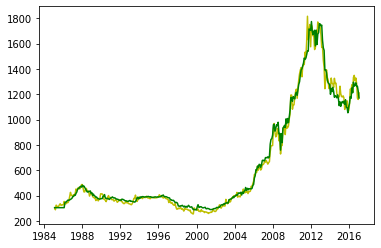

In [13]:
train_df = df.loc[df.index < pd.to_datetime('2016-01-01')]
#val_df = train_df.loc[train_df.index >= pd.to_datetime('2013-01-01')]
#train_df = train_df.loc[train_df.index < pd.to_datetime('2013-01-01')]
#test_df = df.loc[df.index >= pd.to_datetime('2016-01-01')]
#train_x, train_y = create_dataset(train_df, look_back=look_back)
##val_x, val_y = create_dataset(val_df, look_back=look_back)
#test_x, test_y = create_dataset(test_df, look_back=look_back)
timeseries = np.asarray(df.Gold)
timeseries = np.atleast_2d(timeseries)
if timeseries.shape[0] == 1:
        timeseries = timeseries.T
X = np.atleast_3d(np.array([timeseries[start:start + look_back] for start in range(0, timeseries.shape[0] - look_back)]))
y = timeseries[look_back:]

predictors = ['Gold']#, 'DJI','Inflation']#, 'InterestRate']
#TRAIN_SIZE = train_x.shape[0]
#EMB_SIZE = look_back
model = Sequential()
#model.add(Embedding(TRAIN_SIZE, 1, input_length=EMB_SIZE))
model.add(Convolution1D(input_shape = (look_back,1), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Convolution1D(input_shape = (look_back,1), 
                        nb_filter=64,
                        filter_length=2,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=2))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(250))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
model.fit(X, 
          y, 
          epochs=1000, 
          batch_size=80, verbose=1, shuffle=False)



df['Pred'] = df.loc[df.index[0], 'Gold']
for i in range(len(df.index)):
    if i <= look_back:
        continue
    a = None
    for c in predictors:
        b = df.loc[df.index[i-look_back:i], c].as_matrix()
        if a is None:
            a = b
        else:
            a = np.append(a,b)
        a = a
    y = model.predict(a.reshape(1,look_back*len(predictors),1))
    df.loc[df.index[i], 'Pred']=y[0][0]

df.to_hdf('DeepLearning.h5', 'Pred_CNN')
df.loc[:, 'Gold'] = sc.inverse_transform(df.loc[:, 'Gold'])
df.loc[:, 'Pred'] = sc.inverse_transform(df.loc[:, 'Pred'])
plt.plot(df.Gold,'y')
plt.plot(df.Pred, 'g')